## 1] Qu'est ce que le RAG (Retrieval Augmented Generation) ?

Introduit par les équipes de recherche en IA de Meta, le Retrieval Augmented Generation (RAG) est une approche qui consiste à intégrer un mécanisme de recherche d'informations.
Il est possible d'ajouter un contexte lorsque l'on communique avec un LLM, notamment afin de lui fournir des informations supplémentaires, comme des définitions, des exemples ou des situations.

Grâce à la génération augmentée de récupération (RAG) le LLM est en mesure d'avoir accès à une base de connaissances personnalisée. cela permet d'apporter une base de connaissances sous la forme de documents de tout types, afin d'enrichir le LLM avec l'apport d'informations supplémentaires qui en serait pas publiques, ou qui seraient trop spécialisés pour avoir été utilisées lors de la phase d'entraînement.

De manière synthétique, les RAG sont constitués de deux étapes principales.

    Une étape de récupération (retrieval) qui a pour but d'extraire des informations pertinentes depuis la base de connaissances, que ce soit dans une base de données ou dans des documents. 
    
    Une étape de génération où, une fois l'information recherché extraite, un LLM va générer une réponse en langage naturel. L'intérêt d'utiliser un LLM ici est de ne pas directement fournir l'information extraite en brut à un utilisateur, mais de l'embellir avec un texte en langage naturel. À cette étape, plusieurs LLM comme GPT, LLaMa ou encore Mistral peuvent être utilisés.

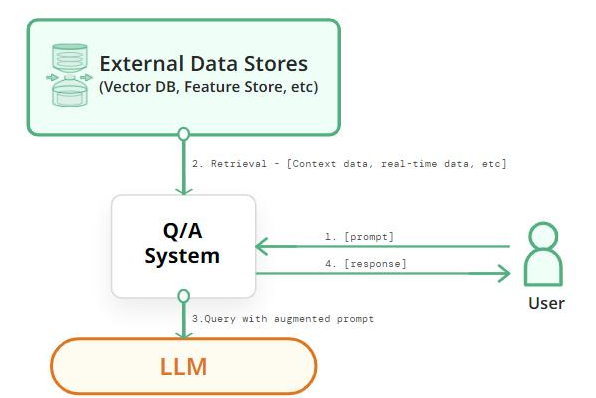

In [204]:
from PIL import Image
im_rag = Image.open("rag.png")
im_rag

On va utiliser le RAG en chargeant les données de ma thèse professionnelle sur l'interprétabilité des modèles en machine learning que j'ai réalisée à la matmut. On posera ensuite des questions à notre modèle LLM sur l'interprétabilité.

## 2] Librairies

In [9]:
from langchain import hub #e module fournit une interface pour interagir avec les modèles de langage hébergés (LLMs). Il permet de charger des modèles de manière centralisée via des hubs (comme Hugging Face)
from langchain.chains import RetrievalQA #permet de créer une chaîne de questions-réponses basée sur la recherche. Il combine un modèle de langage avec un moteur de recherche de documents pour fournir des réponses à des questions à partir d'une collection spécifique de documents.
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler #e callback est utilisé pour gérer les flux de sortie en temps réel dans les applications utilisant des modèles de langage.
from langchain.callbacks.manager import CallbackManager #Le Callback Manager gère les différents événements de retour d'appel. Cela permet de centraliser les callbacks (comme le streaming ou la gestion des erreurs) pour mieux gérer l'exécution des chaînes dans Langchain.
from langchain.llms import Ollama #pour intégrer le modèle Ollama (un modèle de langage comme Llama 2)
from langchain.embeddings.ollama import OllamaEmbeddings #Ce module convertit des textes en vecteurs d'embeddings (représentations numériques) en utilisant le modèle Ollama
from langchain.vectorstores import Chroma #Chroma est un moteur de stockage de vecteurs qui permet de stocker et d'interroger des embeddings vectoriels.
from langchain.text_splitter import RecursiveCharacterTextSplitter #permet de diviser un texte en morceaux plus petits (segments). La méthode RecursiveCharacterTextSplitter découpe un texte en fonction de caractères (par exemple, espaces ou ponctuation) tout en respectant une limite de caractères, pour s'assurer que les segments ne dépassent pas une certaine longueur.
from langchain.document_loaders import PyPDFLoader # pour charger et traiter des documents PDF
from langchain.prompts import PromptTemplate # créer des templates de prompts pour les modèles de langage. Les prompts sont des instructions que l'on envoie aux LLMs pour guider leur génération de texte. Le PromptTemplate aide à standardiser ces instructions en les rendant paramétrables.
from langchain.memory import ConversationBufferMemory #stocke la mémoire conversationnelle d'un utilisateur, permettant de maintenir le contexte conversationnel dans des interactions avec un modèle de langage. Cela est crucial pour les systèmes de dialogue où les réponses doivent se baser sur les interactions passées.
import os
import time

In [11]:
FILEPATH    = "Thèse_matmut.pdf"  #Le fichier pdf : on va l'utiliser sur le document de ma thèse professionnelle à la Matmut
LOCAL_MODEL = "llama2" #modèle LLM : télécharger avec la commande "ollama pull llama2" dans l'invite de commande 
EMBEDDING   = "nomic-embed-text" #mots transformés en vecteur numérique : télécharger avec la commande"ollama pull nomic-embed-text" dans l'invite de commande

# 3] Les étapes 

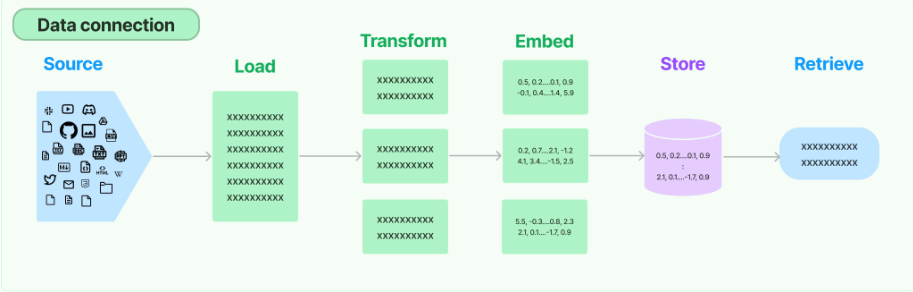

In [202]:
from PIL import Image
im = Image.open("Data connection.png")
im

### 3.1] Load and Transform : Chargement du document PDF

In [14]:
#Etape 3 : chargé document PDF
loader = PyPDFLoader(FILEPATH)
data = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500, chunk_overlap=100) #chaque segment (ou "chunk") de texte aura une taille maximale de 1500 caractères. Il y aura un chevauchement de 100 caractères entre les segments successifs. Cela garantit qu'une petite partie de la fin d'un segment sera répétée au début du segment suivant. Ce chevauchement peut être utile pour maintenir le contexte dans les modèles qui traitent des segments isolés.
all_splits = text_splitter.split_documents(data)

C:\Users\flori\anaconda3\Lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


$\underline{Explication}$ 
    
    Si on a un document de 3000 caractères dans data, il sera divisé en 2 morceaux de 1500 caractères, avec 100 caractères en commun entre les deux morceaux.
    Ce type de découpage est souvent utilisé dans des applications de recherche par similarité ou des systèmes de question-réponse basés sur des documents volumineux, où il faut traiter chaque segment séparément pour rester dans les limites de taille des modèles tout en conservant le contexte grâce au chevauchement.

### 3.2] Embed and Store 

In [23]:
persist_directory = 'data' #création du fichier data 

vectorstore = Chroma.from_documents( #crée une base de donnée vectoriel à partir d'une collection de document.
    documents=all_splits,  #contient les segments de texte (chunks) / séparation de texte dans le document
    embedding=OllamaEmbeddings(model=EMBEDDING), #OllamaEmbeddings est utilisé pour générer les embeddings des documents à partir d'un modèle de langage (ici Ollama). Ce modèle convertit chaque segment de texte en une représentation vectorielle, qui capture le sens sémantique du texte.
    persist_directory=persist_directory #sauvegarder la base de donnée vectorielle dans le dossier data
)

# vectorstore.persist()

### 3.3] Retrieve : Utilisation du modèle

In [25]:
llm = Ollama(base_url="http://localhost:11434", #Le modèle est en cours d'exécution sur la machine locale (localhost) sur le port 11434
                                  model=LOCAL_MODEL, #le modèle spécifique que l'on souhaite utiliser
                                  verbose=True, #le modèle peut fournir des informations supplémentaires sur ce qu'il fait (comme les journaux d'activité) lors de l'exécution
                                  callback_manager=CallbackManager( # gestionnaire de rappels (callbacks) qui permet de gérer les événements
                                      [StreamingStdOutCallbackHandler()]) #envoie des mises à jour (ou des sorties) à la console (standard output) en temps réel. Cela peut être utile pour voir les résultats au fur et à mesure qu'ils sont générés par le modèle.
                                  )

retriever = vectorstore.as_retriever()

In [27]:
llm

Ollama(verbose=True, callbacks=<langchain_core.callbacks.manager.CallbackManager object at 0x0000017D86BBD450>)

## 4] Test du modèle Ollama

In [213]:
prompt = " Donne moi les critères d'un modèle de machine learning interprétable en français, fait court." #"Explain the concept of machine learning in simple terms."
response = llm(prompt)


 Voici quelques critères clés pour un modèle de machine learning interprétable en français :

1. Explicabilité des décisions : le modèle doit être capable de fournir des explications claires et concises pour les décisions qu'il prend.
2. Interprétabilité des données : le modèle doit être capable de s'intégrer aux données d'entrée et de produire des résultats compréhensibles.
3. Transparence : le modèle doit être transparent dans ses processus de prise de décisions, ce qui signifie qu'il doit être possible de comprendre comment il arrive à ses résultats.
4. Accurace : le modèle doit être capable de produire des résultats précis et fiables.
5. Robustesse : le modèle doit être capable de fonctionner bien même lorsque les données d'entrée sont imparfaitement structurées ou contiennent des erreurs.
6. Adaptabilité : le modèle doit être capable d'adapter lui-même en fonction des données et des contextes d'utilisation.
7. Interaction avec l'utilisateur : le modèle doit être capable de s'inté

## 5] Définir les prompt et la gestion de la mémoire

In [154]:
template = """ Vous êtes un chatbot expérimenté, là pour répondre aux questions de l'utilisateur. Votre ton doit être professionnel et informatif. Vous devez absolument répondre en français.
    
    Contexte : {context}
    Historique : {history}

    Utilisateur : {question}
    Chatbot (répond toujours en français) :
    """
prompt = PromptTemplate(
        input_variables=["history", "context", "question"],
        template=template,
    )

memory = ConversationBufferMemory(
        memory_key="history",
        return_messages=True,
        input_key="question"
    )

## 6] Configuration : chaîne de questions-réponses 

In [157]:
qa_chain = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type='stuff', #Le type "stuff" est généralement utilisé pour un traitement simple, où tous les documents récupérés sont assemblés dans un seul texte avant d'être traités par le modèle de langage
            retriever=retriever,
            verbose=True,
            chain_type_kwargs={
                "verbose": True,
                "prompt": prompt,
                "memory": memory,
            }
        )

In [159]:
query = "Donne moi les critères d'un modèle de machine learning interprétable en français."
query += ". Uniquement avec les informations du pdf,  fait court"

In [161]:
response_rag = qa_chain.invoke({"query": query})
response_rag



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
 Vous êtes un chatbot expérimenté, là pour répondre aux questions de l'utilisateur. Votre ton doit être professionnel et informatif. Vous devez absolument répondre en français.
    
    Contexte : interprétables comme le GLM sont-ils nécessairement faciles à interpréter? On peut prendre comme exemple, dans
la tarification automobile, un modèle GLM qui a été construite et qui possède plus de 300 coefficients. On peut
se demander alors s’il est réellement plus facile d’interpréter un tel modèle GLM par rapport à un modèle plus
complexe comme les forêts aléatoires, qui est considéré comme un modèle de boite noire.
Un modèle interprétable peut alors se définir par sa :
Parcimonie :La parcimonie est étroitement liée au principe du rasoir d’Ockham, qui stipule que « les mul-
tiples ne doivent pas être utilisés sans nécessité ». Dans le cas d’un modèl

{'query': "Donne moi les critères d'un modèle de machine learning interprétable en français.. Uniquement avec les informations du pdf,  fait court",
 'result': "Bonjour ! Un modèle de machine learning interprétable est un modèle qui permet une compréhension et une explication facilitées de ses décisions. Pour un modèle de machine learning être interprétable, il doit répondre à plusieurs critères :\n\n1. Parcimonie : le modèle doit être limité dans le nombre d'parameters non nuls, ce qui permet de réduire la complexité du modèle et d'améliorer sa compréhension.\n2. Simulabilité : le modèle doit être capable de se reproduire et d'être expliqué par des humains. Cela signifie que les décisions prises par le modèle doivent être compréhensibles et justifiables.\n3. La prise de décision juste et éthique : le modèle doit être capable de prendre des décisions équitables et éthiques, sans discrimination ni traitement défavorable envers une personne ou un groupe de personnes.\n4. La transférabili

In [139]:
result_response_rag = response_rag["result"]
result_response_rag

"Bonjour ! Pour définir un modèle de machine learning interprétable, il est important de considérer trois critères : la parcimonie, la simulabilité et la modularité.\n\n1. Parcimonie : La parcimonie est étroitement liée au principe du rasoir d'Ockham, qui stipule que « les multiples ne doivent pas être utilisés sans nécessité ». Dans le cas d'un modèle de machine learning, imposé que le modèle soit parcimonieux revient à limiter le nombre de paramètres non nuls. En statistique et en apprentissage automatique, il existe différentes méthodes de régularisation, applicables à de nombreux modèles.\n2. Simulabilité : Murdoch and Singh (2019) définissent un modèle qui est simulable si un humain est capable de reproduire le processus de décision global de l'algorithme. Il doit être capable, à partir des données d'entrée du modèle et des paramètres, de réaliser l'ensemble des calculs pour reconstruire la prédiction faite par le modèle. Ce qui demande une transparence totale du modèle.\n3. Modul

## 7] Evaluation du modèle

Si on souhaite évaluer la quantité et la qualité des informations retournées par les modèles, y compris lorsque les réponses peuvent être formulées de manière différente mais restent sémantiquement correctes, le score $\textbf{ROUGE}$ est plus adapté.

In [143]:
print(response) 


 Un modèle de machine learning interprétable est un modèle qui permet de comprendre et d'interpréter les résultats qu'il produit. Voici quelques-uns des critères clés pour une interprétabilité satisfaisante :

1. Explicability : le modèle doit être capable de fournir des explications détaillées pour ses résultats. Cela signifie que le modèle doit être en mesure de préciser les facteurs qui ont influencé son résultat final.
2. Interprétabilité des weights : les poids du modèle doivent être interprétés de manière compréhensible. Les poids doivent être reliés aux caractéristiques du données et doivent être facilement compréhensibles pour les utilisateurs non experts.
3. Transparence : le modèle doit être transparent dans son fonctionnement. Cela signifie que le modèle doit être facile à comprendre, et que les algorithmes utilisés doivent être clairs et faciles à interpréter.
4. Interrogation : le modèle doit permettre des interrogations sur les résultats qu'il produit. Les utilisateurs d

In [145]:
result_response_rag

"Bonjour ! Pour définir un modèle de machine learning interprétable, il est important de considérer trois critères : la parcimonie, la simulabilité et la modularité.\n\n1. Parcimonie : La parcimonie est étroitement liée au principe du rasoir d'Ockham, qui stipule que « les multiples ne doivent pas être utilisés sans nécessité ». Dans le cas d'un modèle de machine learning, imposé que le modèle soit parcimonieux revient à limiter le nombre de paramètres non nuls. En statistique et en apprentissage automatique, il existe différentes méthodes de régularisation, applicables à de nombreux modèles.\n2. Simulabilité : Murdoch and Singh (2019) définissent un modèle qui est simulable si un humain est capable de reproduire le processus de décision global de l'algorithme. Il doit être capable, à partir des données d'entrée du modèle et des paramètres, de réaliser l'ensemble des calculs pour reconstruire la prédiction faite par le modèle. Ce qui demande une transparence totale du modèle.\n3. Modul

In [147]:
#Importer le module
from rouge_score import rouge_scorer

In [163]:
#Créer un objet RougeScorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

#Calculer les scores ROUGE
scores = scorer.score(result_response_rag, response)

#Afficher les résultats
print("Scores ROUGE:")
print(f"ROUGE-1: {scores['rouge1']}") #rappel
print(f"ROUGE-2: {scores['rouge2']}") #précision
print(f"ROUGE-L: {scores['rougeL']}") #score F1

Scores ROUGE:
ROUGE-1: Score(precision=0.4413793103448276, recall=0.4740740740740741, fmeasure=0.4571428571428572)
ROUGE-2: Score(precision=0.1522491349480969, recall=0.16356877323420074, fmeasure=0.15770609318996417)
ROUGE-L: Score(precision=0.21724137931034482, recall=0.23333333333333334, fmeasure=0.225)


Le score ROUGE, qui évalue la qualité des réponses générées par rapport à une référence, varie selon le contexte et le domaine. Voici un aperçu de ce que tu pourrais considérer comme des scores typiques :

Interprétation des scores ROUGE
    ROUGE-1 (Unigram) :

    Score élevé (0.5 à 1.0) : Indique une bonne correspondance de vocabulaire. Les scores proches de 1.0 montrent que la réponse générée contient une grande partie du vocabulaire de la référence.
    Score moyen (0.3 à 0.5) : Peut être acceptable, mais il indique qu'il manque des mots clés importants dans la réponse générée.
    Score faible (< 0.3) : Indique une mauvaise correspondance et suggère que la réponse générée n'a pas utilisé les termes appropriés.

ROUGE-2 (Bigram) :

    Score élevé (0.4 à 1.0) : Indique que la réponse générée conserve non seulement des mots individuels, mais aussi des combinaisons de mots (expressions clés).
    Score moyen (0.2 à 0.4) : Peut être acceptable, mais des améliorations sont nécessaires pour capturer des expressions clés.
    Score faible (< 0.2) : Indique que la réponse générée est largement différente de la référence.

ROUGE-L (Longueur de la plus longue sous-séquence) :

    Score élevé (0.5 à 1.0) : Indique que la structure de la réponse générée est similaire à celle de la référence, ce qui est important pour la cohérence.
    Score moyen (0.3 à 0.5) : Indique une certaine similarité mais suggère qu'il pourrait y avoir des différences significatives dans la structure.
    Score faible (< 0.3) : Indique que la réponse générée a une structure différente de celle de la référence.

Contextualisation des scores

    Modèles de haute performance : Pour des modèles bien entraînés et optimisés, tu peux t'attendre à des scores ROUGE-1 et ROUGE-2 d'au moins 0.4 à 0.5.

Réponses d'experts 

    Pour les applications critiques, comme les résumés automatiques ou les systèmes de question-réponse, des scores supérieurs à 0.6 sont souvent souhaitables.